<a href="https://colab.research.google.com/github/rmorlowski/Generalized-Linear-Models/blob/master/Wine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Wine Sales

The deliverable is to analyze wine chemistry data to predict the number of cases of wine sold by a manufacturer. This will be accomplished through exploratory data analysis and by generating negative binomial, Poisson, and other regression models. Different variable selection techniques including but not limited to forward, stepwise, and backward regression will be tested to improve model performance. From these techniques, the best model will be selected by comparing Pseudo R-squared, Akaike Information Criteria (AIC), RMSE scores, complexity, and coefficient behavior. The best model will then be further analyzed to determine if it is an adequate model to predict the number of cases of wine sold or if further analysis or data transformation is necessary.

![alt text](https://www.heritagepark.ca/_images/1140x430---wine-maker.jpg)

In [0]:
#Recommend you work to improve the negative binomial model for scoring this assignment
#If you would like to experiment with a hurdle model try modeling in two steps
#step 1 use logistic regression to predict zero vs not zero
#step 2 for the non zero predictions do a negative binomial or regression model
#Interesting to look at the other models SVM etc applied to the training data but they
#don't do very well for the test data

In [2]:
# import packages for this example
import pandas as pd  
import pandas_profiling
import numpy as np  # arrays and math functions
import matplotlib.pyplot as plt  # static plotting
import statsmodels.formula.api as smf  # R-like model specification
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn import feature_selection
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import OLS
from statsmodels.miscmodels.count import PoissonGMLE, PoissonZiGMLE
from statsmodels.genmod.families.family import Poisson, NegativeBinomial
import seaborn as sns
from scipy import stats
from scipy.stats import kurtosis, skew
from scipy.special import boxcox1p

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [0]:
#Set some display options
%matplotlib inline
pd.set_option('display.notebook_repr_html', False) 
pd.set_option('display.max_columns', 40) 
pd.set_option('display.max_rows', 10) 
pd.set_option('display.width', 120)

In [4]:
# Import file to google colaboratory
from google.colab import files
# upload the train dataset
uploaded = files.upload()

Saving wine_train.csv to wine_train.csv


In [0]:
import io
#Read in the wine training dataset
train = pd.read_csv('wine_train.csv')

In [6]:
# Import file to google colaboratory
# upload the test dataset
uploaded = files.upload()

Saving wine_test.csv to wine_test.csv


In [0]:
#Read in the wine testing dataset
test = pd.read_csv('wine_test.csv')

In [8]:
#A good step to take is to convert all variable names to lower case
train.columns = [s.lower() for s in train.columns]
test.columns = [s.lower() for s in test.columns]
print(train)
print(test)

       index  target  fixedacidity  volatileacidity  citricacid  residualsugar  chlorides  freesulfurdioxide  \
0          1       3           3.2            1.160       -0.98           54.2     -0.567                NaN   
1          2       3           4.5            0.160       -0.81           26.1     -0.425               15.0   
2          4       5           7.1            2.640       -0.88           14.8      0.037              214.0   
3          5       3           5.7            0.385        0.04           18.8     -0.425               22.0   
4          6       4           8.0            0.330       -1.26            9.4        NaN             -167.0   
...      ...     ...           ...              ...         ...            ...        ...                ...   
12790  16120       0           5.0           -0.790        2.01            5.0      0.043               17.0   
12791  16123       5           8.9            0.470        0.29           84.9      0.259               

In [9]:
print('')
print('----- Summary of Input Data -----')
print('')


----- Summary of Input Data -----



In [10]:
pandas_profiling.ProfileReport(train)

Number of variables,16
Number of observations,12795
Total Missing (%),4.0%
Total size in memory,1.6 MiB
Average record size in memory,128.0 B
Numeric,16
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [11]:
# show the object is a DataFrame
print('Object type: ', type(train))

Object type:  <class 'pandas.core.frame.DataFrame'>


In [12]:
# show number of observations in the DataFrame
print('Number of observations: ', len(train))

Number of observations:  12795


In [13]:
# show variable names
print('Variable names: ', train.columns)

Variable names:  Index(['index', 'target', 'fixedacidity', 'volatileacidity', 'citricacid', 'residualsugar', 'chlorides',
       'freesulfurdioxide', 'totalsulfurdioxide', 'density', 'ph', 'sulphates', 'alcohol', 'labelappeal', 'acidindex',
       'stars'],
      dtype='object')


In [14]:
# show descriptive statistics
print(train.describe())

              index        target  fixedacidity  volatileacidity    citricacid  residualsugar     chlorides  \
count  12795.000000  12795.000000  12795.000000     12795.000000  12795.000000   12179.000000  12157.000000   
mean    8069.980305      3.029074      7.075717         0.324104      0.308413       5.418733      0.054822   
std     4656.905107      1.926368      6.317643         0.784014      0.862080      33.749379      0.318467   
min        1.000000      0.000000    -18.100000        -2.790000     -3.240000    -127.800000     -1.171000   
25%     4037.500000      2.000000      5.200000         0.130000      0.030000      -2.000000     -0.031000   
50%     8110.000000      3.000000      6.900000         0.280000      0.310000       3.900000      0.046000   
75%    12106.500000      4.000000      9.500000         0.640000      0.580000      15.900000      0.153000   
max    16129.000000      8.000000     34.400000         3.680000      3.860000     141.150000      1.351000   



In [15]:
#Do we have missing values? 
datasetHasNan = False
if train.count().min() == train.shape[0] and test.count().min() == test.shape[0] :
    print('We do not need to worry about missing values.') 
else:
    datasetHasNan = True
    print('oops we have nan')

oops we have nan


In [16]:
#Check for missing data & list them 
if datasetHasNan == True:
    nas = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1, keys=['Train Dataset', 'Test Dataset']) 
    print('Nan in the data sets')
    print(nas[nas.sum(axis=1) > 0])

Nan in the data sets
                    Train Dataset  Test Dataset
target                          0          3335
residualsugar                 616           168
chlorides                     638           138
freesulfurdioxide             647           152
totalsulfurdioxide            682           157
ph                            395           104
sulphates                    1210           310
alcohol                       653           185
stars                        3359           841


In [17]:
#watch your record count and fix records with missing NaN data
print (train.shape)
train.isnull().sum()
train[train == 0].count()

(12795, 16)


index                 0
target             2734
fixedacidity         39
volatileacidity      18
citricacid          115
                   ... 
sulphates            22
alcohol               2
labelappeal        5617
acidindex             0
stars                 0
Length: 16, dtype: int64

In [0]:
# Add missing indicator variables for analysis to train
# add new missing label appeal
train["miss_label"] = (train['labelappeal'].isna()) | (train['labelappeal'] == 0)
train.miss_label = train.miss_label.astype(int)
# add new missing alcohol
train["miss_alcohol"] = (train['alcohol'].isna()) | (train['alcohol'] == 0)
train.miss_alcohol = train.miss_alcohol.astype(int)
# add new missing volatile acidity
train["miss_va"] = (train['volatileacidity'].isna()) | (train['volatileacidity'] == 0)
train.miss_va = train.miss_va.astype(int)
# add new missing chlorides
train["miss_chlorides"] = (train['chlorides'].isna()) | (train['chlorides'] == 0)
train.miss_chlorides = train.miss_chlorides.astype(int)
# add new missing fs dioxide
train["miss_fsdioxide"] = (train['freesulfurdioxide'].isna()) | (train['freesulfurdioxide'] == 0)
train.miss_fsdioxide = train.miss_fsdioxide.astype(int)
# add new missing ph
train["miss_ph"] = (train['ph'].isna()) | (train['ph'] == 0)
train.miss_ph = train.miss_ph.astype(int)
# add new missing residualsugar
train["miss_sugar"] = (train['residualsugar'].isna()) | (train['residualsugar'] == 0)
train.miss_sugar = train.miss_sugar.astype(int)
# add new missing sulphates
train["miss_sulphates"] = (train['sulphates'].isna()) | (train['sulphates'] == 0)
train.miss_sulphates = train.miss_sulphates.astype(int)
# add new missing totalsulfurdioxide
train["miss_totalsfdioxide"] = (train['totalsulfurdioxide'].isna()) | (train['totalsulfurdioxide'] == 0)
train.miss_totalsfdioxide = train.miss_totalsfdioxide.astype(int)

In [19]:
# Add missing indicator variables for analysis to test
# add new missing label appeal
test["miss_label"] = (test['labelappeal'].isna()) | (test['labelappeal'] == 0)
test.miss_label = test.miss_label.astype(int)
# add new missing alcohol
test["miss_alcohol"] = (test['alcohol'].isna()) | (test['alcohol'] == 0)
test.miss_alcohol = test.miss_alcohol.astype(int)
# add new missing volatile acidity
test["miss_va"] = (test['volatileacidity'].isna()) | (test['volatileacidity'] == 0)
test.miss_va = test.miss_va.astype(int)
# add new missing chlorides
test["miss_chlorides"] = (test['chlorides'].isna()) | (test['chlorides'] == 0)
test.miss_chlorides = test.miss_chlorides.astype(int)
# add new fs dioxide
test["miss_fsdioxide"] = (test['freesulfurdioxide'].isna()) | (test['freesulfurdioxide'] == 0)
test.miss_fsdioxide = test.miss_fsdioxide.astype(int)
# add new missing ph
test["miss_ph"] = (test['ph'].isna()) | (test['ph'] == 0)
test.miss_ph = test.miss_ph.astype(int)
# add new missing residualsugar
test["miss_sugar"] = (test['residualsugar'].isna()) | (test['residualsugar'] == 0)
test.miss_sugar = test.miss_sugar.astype(int)
# add new missing sulphates
test["miss_sulphates"] = (test['sulphates'].isna()) | (test['sulphates'] == 0)
test.miss_sulphates = test.miss_sulphates.astype(int)
# add new missing total sulfur dioxide
test["miss_totalsfdioxide"] = (test['totalsulfurdioxide'].isna()) | (test['totalsulfurdioxide'] == 0)
test.miss_miss_totalsfdioxide = test.miss_totalsfdioxide.astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [0]:
#watch the count it will tell you if a variable has some missing values that you will need to deal with
#train=train.fillna(0)

#Replace NaN values with something else
#residual sugar
train=train.replace({'residualsugar': {np.NaN : 5}})
#chlorides
train=train.replace({'chlorides': {np.NaN : 0}})
#freesulfurdioxide
train=train.replace({'freesulfurdioxide': {np.NaN : 31}})
#totalsulfurdioxide
train=train.replace({'totalsulfurdioxide': {np.NaN : 121}})
#pH
train=train.replace({'ph': {np.NaN : 3}})
#sulphates
train=train.replace({'sulphates': {np.NaN : 1}})
#alcohol
train=train.replace({'alcohol': {np.NaN : 10}})
#stars
train=train.replace({'stars': {np.NaN : 0}})
#alcohol
train=train.replace({'alcohol': {np.NaN : 11}})

train['residualsugar'] = abs(train.residualsugar) 
train['chlorides'] = abs(train.chlorides)
train['freesulfurdioxide'] = abs(train.freesulfurdioxide)
train['totalsulfurdioxide'] = abs(train.totalsulfurdioxide)
train['ph'] = abs(train.ph)
train['sulphates'] = abs(train.sulphates)
train['fixedacidity'] = abs(train.fixedacidity) 
train['volatileacidity'] = abs(train.volatileacidity)
train['citricacid'] = abs(train.citricacid)
train['alcohol'] = abs(train.alcohol) 

In [0]:
# Standardize variables by "clipping" data
pct1, pct99 = train.residualsugar.quantile([0.01,0.99])
train.residualsugar.clip(lower = pct1, upper = pct99, inplace = True)
#pct1, pct99 = train.freesulfurdioxide.quantile([0.01,0.99])
#train.freesulfurdioxide.clip(lower = pct1, upper = pct99, inplace = True)
pct1, pct99 = train.alcohol.quantile([0.01,0.99])
train.alcohol.clip(lower = pct1, upper = pct99, inplace = True)
pct1, pct99 = train.density.quantile([0.01,0.99])
train.density.clip(lower = pct1, upper = pct99, inplace = True)

In [0]:
#Make sure whatever you do to the training data you also do to the test data otherwise your model will not score properly
#test=test.fillna(0)

# do the same thing to the test dataset
test=test.replace({'residualsugar': {np.NaN : 5}})
test=test.replace({'chlorides': {np.NaN : 0}})
test=test.replace({'freesulfurdioxide': {np.NaN : 31}})
test=test.replace({'totalsulfurdioxide': {np.NaN : 121}})
test=test.replace({'ph': {np.NaN : 3}})
test=test.replace({'sulphates': {np.NaN : 1}})
test=test.replace({'alcohol': {np.NaN : 10}})
test=test.replace({'stars': {np.NaN : 0}})
 
test['residualsugar'] = abs(test.residualsugar) 
test['chlorides'] = abs(test.chlorides)
test['freesulfurdioxide'] = abs(test.freesulfurdioxide)
test['totalsulfurdioxide'] = abs(test.totalsulfurdioxide)
test['ph'] = abs(test.ph)
test['sulphates'] = abs(test.sulphates)
test['fixedacidity'] = abs(test.fixedacidity) 
test['volatileacidity'] = abs(test.volatileacidity)
test['citricacid'] = abs(test.citricacid)
test['alcohol'] = abs(test.alcohol) 
test=test.replace({'alcohol': {np.NaN : 11}})

In [0]:
# clip test
pct1, pct99 = train.residualsugar.quantile([0.01,0.99])
test.residualsugar.clip(lower = pct1, upper = pct99, inplace = True)
#pct1, pct99 = train.freesulfurdioxide.quantile([0.01,0.99])
#test.freesulfurdioxide.clip(lower = pct1, upper = pct99, inplace = True)
pct1, pct99 = train.alcohol.quantile([0.01,0.99])
test.alcohol.clip(lower = pct1, upper = pct99, inplace = True)
pct1, pct99 = train.density.quantile([0.01,0.99])
test.density.clip(lower = pct1, upper = pct99, inplace = True)

In [24]:
train[train == 0].count()
train[train < 0].count()

index                  0
target                 0
fixedacidity           0
volatileacidity        0
citricacid             0
                      ..
miss_fsdioxide         0
miss_ph                0
miss_sugar             0
miss_sulphates         0
miss_totalsfdioxide    0
Length: 25, dtype: int64

In [25]:
# show descriptive statistics
print(train.describe())

              index        target  fixedacidity  volatileacidity    citricacid  residualsugar     chlorides  \
count  12795.000000  12795.000000  12795.000000     12795.000000  12795.000000   12795.000000  12795.000000   
mean    8069.980305      3.029074      8.063251         0.641086      0.686315      22.383436      0.211461   
std     4656.905107      1.926368      4.996119         0.555614      0.606005      24.241301      0.233453   
min        1.000000      0.000000      0.000000         0.000000      0.000000       0.900000      0.000000   
25%     4037.500000      2.000000      5.600000         0.250000      0.280000       4.000000      0.043000   
50%     8110.000000      3.000000      7.000000         0.410000      0.440000      11.750000      0.086000   
75%    12106.500000      4.000000      9.800000         0.910000      0.970000      37.200000      0.353000   
max    16129.000000      8.000000     34.400000         3.680000      3.860000     112.306000      1.351000   



In [26]:
# For each feature find the data points with extreme high or low values
for feature in train.keys():

    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(train[feature], q=25)
 
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(train[feature], q=75)
 
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    interquartile_range = Q3 - Q1
    step = 3.0 * interquartile_range
 
    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))
    display(train[~((train[feature] >= Q1 - step) & (train[feature] <= Q3 + step))])

Data points considered outliers for the feature 'index':


Empty DataFrame
Columns: [index, target, fixedacidity, volatileacidity, citricacid, residualsugar, chlorides, freesulfurdioxide, totalsulfurdioxide, density, ph, sulphates, alcohol, labelappeal, acidindex, stars, miss_label, miss_alcohol, miss_va, miss_chlorides, miss_fsdioxide, miss_ph, miss_sugar, miss_sulphates, miss_totalsfdioxide]
Index: []

Data points considered outliers for the feature 'target':


Empty DataFrame
Columns: [index, target, fixedacidity, volatileacidity, citricacid, residualsugar, chlorides, freesulfurdioxide, totalsulfurdioxide, density, ph, sulphates, alcohol, labelappeal, acidindex, stars, miss_label, miss_alcohol, miss_va, miss_chlorides, miss_fsdioxide, miss_ph, miss_sugar, miss_sulphates, miss_totalsfdioxide]
Index: []

Data points considered outliers for the feature 'fixedacidity':


       index  target  fixedacidity  volatileacidity  citricacid  residualsugar  chlorides  freesulfurdioxide  \
37        48       4          28.9            0.510        0.49          59.60      0.055               20.0   
50        65       0          24.7            1.630        1.00           1.90      0.846               15.0   
75        96       1          23.6            0.400        0.50           1.00      0.354              174.0   
527      661       2          25.2            0.260        0.30           2.00      0.355               13.0   
583      735       0          27.1            0.715        0.08           2.35      0.431              154.0   
...      ...     ...           ...              ...         ...            ...        ...                ...   
12429  15677       4          23.8            1.310        0.39          38.20      0.044              203.0   
12479  15738       7          25.4            1.450        0.35          66.00      0.175               

Data points considered outliers for the feature 'volatileacidity':


       index  target  fixedacidity  volatileacidity  citricacid  residualsugar  chlorides  freesulfurdioxide  \
95       121       0           0.6            3.060        0.42           19.0      0.009                3.0   
137      177       4           2.7            3.060        1.59            4.9      0.028               25.0   
284      353       4           5.7            3.180        0.26           12.5      0.049              122.5   
451      563       4          17.6            2.955        0.20           74.4      0.071              140.0   
590      742       3          17.0            3.280        1.19           44.4      0.056               56.0   
...      ...     ...           ...              ...         ...            ...        ...                ...   
11944  15057       3           4.7            3.350        0.09            1.9      0.141                5.0   
11985  15108       2           6.8            3.040        0.85           41.4      0.389               

Data points considered outliers for the feature 'citricacid':


       index  target  fixedacidity  volatileacidity  citricacid  residualsugar  chlorides  freesulfurdioxide  \
60        78       0           5.8             0.68        3.26         11.400      0.056               23.0   
258      321       7          11.4             0.65        3.09         70.600      0.421              171.0   
589      741       4           7.5             0.43        3.39          8.800      0.134               59.0   
599      755       5           3.6             0.31        3.68          8.400      0.031               70.0   
777      991       3           2.9             0.45        3.33          1.200      0.259              101.0   
...      ...     ...           ...              ...         ...            ...        ...                ...   
12197  15370       4           0.2             0.30        3.63        112.306      0.180               36.0   
12261  15454       4           6.5             0.75        3.25          1.600      0.279               

Data points considered outliers for the feature 'residualsugar':


Empty DataFrame
Columns: [index, target, fixedacidity, volatileacidity, citricacid, residualsugar, chlorides, freesulfurdioxide, totalsulfurdioxide, density, ph, sulphates, alcohol, labelappeal, acidindex, stars, miss_label, miss_alcohol, miss_va, miss_chlorides, miss_fsdioxide, miss_ph, miss_sugar, miss_sulphates, miss_totalsfdioxide]
Index: []

Data points considered outliers for the feature 'chlorides':


      index  target  fixedacidity  volatileacidity  citricacid  residualsugar  chlorides  freesulfurdioxide  \
5641   7127       0          13.5              0.7        0.29            2.5      1.351                3.0   

      totalsulfurdioxide  density   ph  sulphates  alcohol  labelappeal  acidindex  stars  miss_label  miss_alcohol  \
5641                15.0  0.99365  2.1        0.6     10.7            0         10    0.0           1             0   

      miss_va  miss_chlorides  miss_fsdioxide  miss_ph  miss_sugar  miss_sulphates  miss_totalsfdioxide  
5641        0               0               0        0           0               0                    0  

Data points considered outliers for the feature 'freesulfurdioxide':


       index  target  fixedacidity  volatileacidity  citricacid  residualsugar  chlorides  freesulfurdioxide  \
515      642       0           0.1            1.220        1.18         39.100      1.158              622.0   
609      768       0           7.2            0.250        1.04          2.100      0.492              587.0   
1059    1336       6          17.1            1.030        0.24         15.100      0.621              578.0   
1954    2457       3          10.0            0.460        0.41          9.800      0.178              580.0   
2523    3191       5           6.3            0.520        0.42        112.306      0.158              618.0   
...      ...     ...           ...              ...         ...            ...        ...                ...   
9418   11880       3           3.0            0.290        1.21          5.000      0.000              605.0   
9788   12355       3           5.6            0.295        0.88         40.600      0.269              5

Data points considered outliers for the feature 'totalsulfurdioxide':


       index  target  fixedacidity  volatileacidity  citricacid  residualsugar  chlorides  freesulfurdioxide  \
71        91       0           7.3             0.52        0.97         36.300      0.048              255.0   
123      162       2           5.8             0.18        0.21          6.600      0.000               50.0   
155      198       3           0.8             0.56        0.42          2.300      0.139              453.0   
289      361       0           7.0             0.64        0.17         13.800      0.049              259.0   
363      449       3           6.8             0.92        0.86        112.306      0.052               51.0   
...      ...     ...           ...              ...         ...            ...        ...                ...   
12551  15829       2           3.7             0.17        0.30          8.700      0.079               69.0   
12557  15838       0           8.0             1.41        1.39         23.000      0.278               

Data points considered outliers for the feature 'density':


       index  target  fixedacidity  volatileacidity  citricacid  residualsugar  chlorides  freesulfurdioxide  \
9         13       6           5.5            0.220        0.39           1.80      0.277               62.0   
11        15       4           9.0            0.220        0.49          10.40      0.150               31.0   
26        34       4           6.4            2.210        0.56          40.40      0.055               27.0   
97       124       3           1.3            0.640        0.30           2.25      0.034                8.0   
104      137       4          10.5            0.270        1.86          58.80      0.438               17.0   
...      ...     ...           ...              ...         ...            ...        ...                ...   
12711  16030       2           7.5            0.160        0.19          12.10      0.066              283.0   
12715  16034       3           1.9            0.260        0.27          45.10      0.176               

Data points considered outliers for the feature 'ph':


       index  target  fixedacidity  volatileacidity  citricacid  residualsugar  chlorides  freesulfurdioxide  \
8         12       3          14.8            0.270        1.05          11.25      0.007              213.0   
14        19       4          21.8            0.510        1.83           2.90      0.165               49.0   
40        51       0           3.2            0.470        0.30          41.70      0.058              160.0   
41        52       5          13.0            0.340        0.46           4.70      0.029              244.0   
49        61       4           7.5            1.430        1.24           4.40      0.057               22.0   
...      ...     ...           ...              ...         ...            ...        ...                ...   
12640  15941       4           0.4            0.655        0.34          10.80      0.972              135.0   
12670  15979       4          11.5            0.330        0.38           2.50      0.467               

Data points considered outliers for the feature 'sulphates':


       index  target  fixedacidity  volatileacidity  citricacid  residualsugar  chlorides  freesulfurdioxide  \
24        32       4          11.3             0.17        0.34           15.6      0.044              330.0   
26        34       4           6.4             2.21        0.56           40.4      0.055               27.0   
107      140       3           4.0             1.04        0.19           43.3      0.050              294.0   
116      153       5          19.8             0.32        0.33            0.9      0.027              488.0   
287      356       1          11.9             0.57        0.10           10.0      0.094              273.0   
...      ...     ...           ...              ...         ...            ...        ...                ...   
12555  15834       1           5.9             1.04        0.37           69.4      0.568               46.0   
12590  15875       4           6.2             0.24        0.27           44.0      0.618              2

Data points considered outliers for the feature 'alcohol':


Empty DataFrame
Columns: [index, target, fixedacidity, volatileacidity, citricacid, residualsugar, chlorides, freesulfurdioxide, totalsulfurdioxide, density, ph, sulphates, alcohol, labelappeal, acidindex, stars, miss_label, miss_alcohol, miss_va, miss_chlorides, miss_fsdioxide, miss_ph, miss_sugar, miss_sulphates, miss_totalsfdioxide]
Index: []

Data points considered outliers for the feature 'labelappeal':


Empty DataFrame
Columns: [index, target, fixedacidity, volatileacidity, citricacid, residualsugar, chlorides, freesulfurdioxide, totalsulfurdioxide, density, ph, sulphates, alcohol, labelappeal, acidindex, stars, miss_label, miss_alcohol, miss_va, miss_chlorides, miss_fsdioxide, miss_ph, miss_sugar, miss_sulphates, miss_totalsfdioxide]
Index: []

Data points considered outliers for the feature 'acidindex':


       index  target  fixedacidity  volatileacidity  citricacid  residualsugar  chlorides  freesulfurdioxide  \
31        41       0          22.2            0.340        0.49            5.0      0.073               56.0   
50        65       0          24.7            1.630        1.00            1.9      0.846               15.0   
65        84       0          16.3            0.330        0.49            2.5      0.631                8.0   
176      222       3           4.4            0.130        1.61          101.1      0.077              121.0   
183      233       0          10.0            0.350        0.53            2.6      0.070              253.0   
...      ...     ...           ...              ...         ...            ...        ...                ...   
12677  15989       3          16.4            0.170        1.86           41.2      0.082              516.0   
12740  16065       0           9.2            0.600        0.02           46.4      0.203              2

Data points considered outliers for the feature 'stars':


Empty DataFrame
Columns: [index, target, fixedacidity, volatileacidity, citricacid, residualsugar, chlorides, freesulfurdioxide, totalsulfurdioxide, density, ph, sulphates, alcohol, labelappeal, acidindex, stars, miss_label, miss_alcohol, miss_va, miss_chlorides, miss_fsdioxide, miss_ph, miss_sugar, miss_sulphates, miss_totalsfdioxide]
Index: []

Data points considered outliers for the feature 'miss_label':


Empty DataFrame
Columns: [index, target, fixedacidity, volatileacidity, citricacid, residualsugar, chlorides, freesulfurdioxide, totalsulfurdioxide, density, ph, sulphates, alcohol, labelappeal, acidindex, stars, miss_label, miss_alcohol, miss_va, miss_chlorides, miss_fsdioxide, miss_ph, miss_sugar, miss_sulphates, miss_totalsfdioxide]
Index: []

Data points considered outliers for the feature 'miss_alcohol':


       index  target  fixedacidity  volatileacidity  citricacid  residualsugar  chlorides  freesulfurdioxide  \
1          2       3           4.5             0.16        0.81           26.1      0.425               15.0   
56        72       4          15.1             0.44        0.22            4.3      0.992                3.0   
57        73       2          16.0             0.23        0.42            3.8      0.094               49.0   
68        88       3           3.2             0.20        0.37            5.0      0.535              227.0   
91       116       0          12.4             0.38        1.70            2.0      0.080              173.0   
...      ...     ...           ...              ...         ...            ...        ...                ...   
12719  16038       4           1.8             0.28        0.49            7.9      0.138               26.0   
12775  16103       0           5.8             1.29        0.54           30.6      0.824               

Data points considered outliers for the feature 'miss_va':


       index  target  fixedacidity  volatileacidity  citricacid  residualsugar  chlorides  freesulfurdioxide  \
426      531       6           5.2              0.0        0.45          49.40      0.022               14.0   
548      683       5          16.8              0.0        0.35          11.10      0.039               29.0   
1028    1302       4           6.1              0.0        0.33           3.50      0.174               23.0   
1138    1433       0           0.8              0.0        0.65           2.50      1.026               31.0   
1508    1906       4           6.8              0.0        0.07          38.70      0.044              125.0   
...      ...     ...           ...              ...         ...            ...        ...                ...   
10016  12623       6           8.7              0.0        1.96           4.80      0.018              176.0   
11150  14056       4           5.4              0.0        1.82          67.00      0.079               

Data points considered outliers for the feature 'miss_chlorides':


       index  target  fixedacidity  volatileacidity  citricacid  residualsugar  chlorides  freesulfurdioxide  \
4          6       4           8.0             0.33        1.26            9.4        0.0              167.0   
38        49       0           6.9             0.30        0.29            1.3        0.0               24.0   
62        80       4           7.0             0.06        1.57           41.4        0.0               29.0   
70        90       4           6.9             2.75        0.33           16.8        0.0              161.0   
87       111       5           3.5             0.27        1.04            5.0        0.0              352.0   
...      ...     ...           ...              ...         ...            ...        ...                ...   
12625  15923       3           3.9             0.05        1.31           57.0        0.0               70.0   
12657  15962       5           2.3             0.27        0.28            4.5        0.0               

Data points considered outliers for the feature 'miss_fsdioxide':


       index  target  fixedacidity  volatileacidity  citricacid  residualsugar  chlorides  freesulfurdioxide  \
0          1       3           3.2             1.16        0.98           54.2      0.567               31.0   
11        15       4           9.0             0.22        0.49           10.4      0.150               31.0   
46        57       4          11.0             0.23        1.42           37.8      0.035               31.0   
52        67       4           7.1             0.28        0.64           47.1      0.512               31.0   
98       127       4           7.2             0.15        1.42           38.4      0.038               31.0   
...      ...     ...           ...              ...         ...            ...        ...                ...   
12715  16034       3           1.9             0.26        0.27           45.1      0.176               31.0   
12732  16054       3          17.7             0.46        1.84           57.6      0.414               

Data points considered outliers for the feature 'miss_ph':


       index  target  fixedacidity  volatileacidity  citricacid  residualsugar  chlorides  freesulfurdioxide  \
37        48       4          28.9             0.51        0.49          59.60      0.055               20.0   
58        74       4           6.2             0.16        0.26          12.05      0.204              208.0   
82       104       4          11.8             0.88        0.26           6.80      0.298               36.0   
111      145       0           1.9             0.47        0.86          58.10      0.174               24.0   
126      165       2           9.0             0.94        0.81          67.20      0.499               58.0   
...      ...     ...           ...              ...         ...            ...        ...                ...   
12555  15834       1           5.9             1.04        0.37          69.40      0.568               46.0   
12585  15870       4           7.8             1.80        0.78          66.00      0.481               

Data points considered outliers for the feature 'miss_sugar':


       index  target  fixedacidity  volatileacidity  citricacid  residualsugar  chlorides  freesulfurdioxide  \
31        41       0          22.2             0.34        0.49            5.0      0.073               56.0   
68        88       3           3.2             0.20        0.37            5.0      0.535              227.0   
86       110       4           2.9             0.63        1.63            5.0      0.327               24.0   
87       111       5           3.5             0.27        1.04            5.0      0.000              352.0   
125      164       4          11.0             0.38        0.26            5.0      0.035              167.0   
...      ...     ...           ...              ...         ...            ...        ...                ...   
12705  16021       0           6.4             0.30        0.08            5.0      0.001               14.0   
12731  16053       5          10.7             0.46        0.03            5.0      0.217               

Data points considered outliers for the feature 'miss_sulphates':


       index  target  fixedacidity  volatileacidity  citricacid  residualsugar  chlorides  freesulfurdioxide  \
7         11       4           6.5            1.220        0.34            1.4      0.040              523.0   
15        20       0           5.7            0.500        0.11            6.1      0.071              234.0   
28        36       4           8.0            0.010        1.10           44.8      0.350               17.0   
34        44       4           7.9            0.560        0.72           58.8      0.920              127.0   
36        46       0           2.9            1.035        1.11            6.0      0.073              207.0   
...      ...     ...           ...              ...         ...            ...        ...                ...   
12768  16095       6          18.9            0.965        0.60           65.8      0.564              173.0   
12784  16112       6           6.4            0.690        0.09           53.9      0.044               

Data points considered outliers for the feature 'miss_totalsfdioxide':


       index  target  fixedacidity  volatileacidity  citricacid  residualsugar  chlorides  freesulfurdioxide  \
8         12       3          14.8             0.27        1.05          11.25      0.007              213.0   
13        17       7          14.9             0.32        0.34           1.30      0.042               20.0   
27        35       6           8.3             2.46        0.27          13.20      0.036               31.0   
35        45       5          14.8             1.17        0.09           1.50      0.027              166.0   
74        95       2           8.1             0.46        0.09           3.30      0.096               26.0   
...      ...     ...           ...              ...         ...            ...        ...                ...   
12693  16007       0           6.8             0.90        0.69          54.20      0.380               49.0   
12747  16072       0           7.4             0.61        0.01           2.00      0.299              1

index                      AxesSubplot(0.125,0.77;0.133621x0.11)
target                  AxesSubplot(0.285345,0.77;0.133621x0.11)
fixedacidity             AxesSubplot(0.44569,0.77;0.133621x0.11)
volatileacidity         AxesSubplot(0.606034,0.77;0.133621x0.11)
citricacid              AxesSubplot(0.766379,0.77;0.133621x0.11)
                                         ...                    
miss_fsdioxide            AxesSubplot(0.125,0.242;0.133621x0.11)
miss_ph                AxesSubplot(0.285345,0.242;0.133621x0.11)
miss_sugar              AxesSubplot(0.44569,0.242;0.133621x0.11)
miss_sulphates         AxesSubplot(0.606034,0.242;0.133621x0.11)
miss_totalsfdioxide    AxesSubplot(0.766379,0.242;0.133621x0.11)
Length: 25, dtype: object

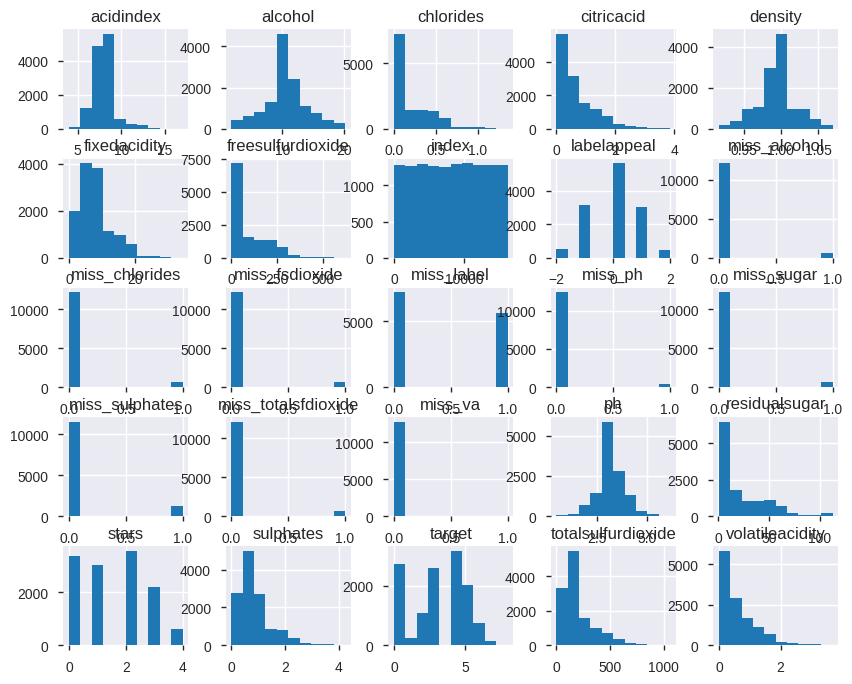

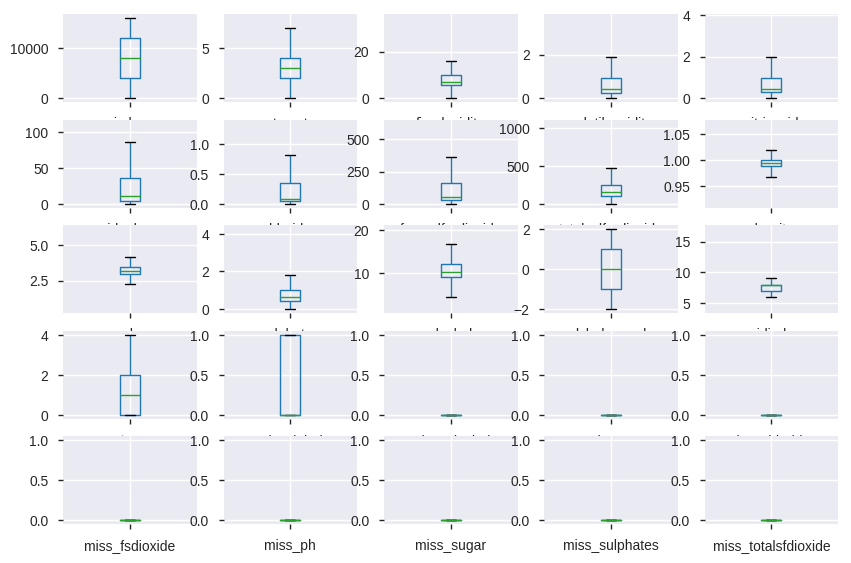

In [27]:
#///Do some EDA///;
#Some quick plots of the data
train.hist(figsize=(10,8))
train.plot(kind= 'box' , subplots=True, layout=(6,5), sharex=False, sharey=False, figsize=(10,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b7f761630>]],
      dtype=object)

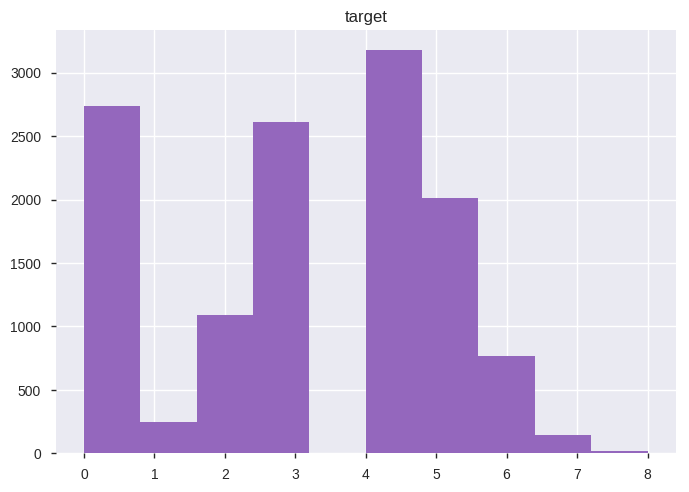

In [28]:
# Let's look at a histogram of the target variable
train.hist("target", color='tab:purple')

In [29]:
# Let's look at the mean and variance
#mean
train.target.mean()

3.0290738569753812

In [30]:
#variance
np.var(train['target'])

3.710604495912717

**Note:  the variance is greater than the mean, suggesting the possibility of a negative binomial distribution**

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


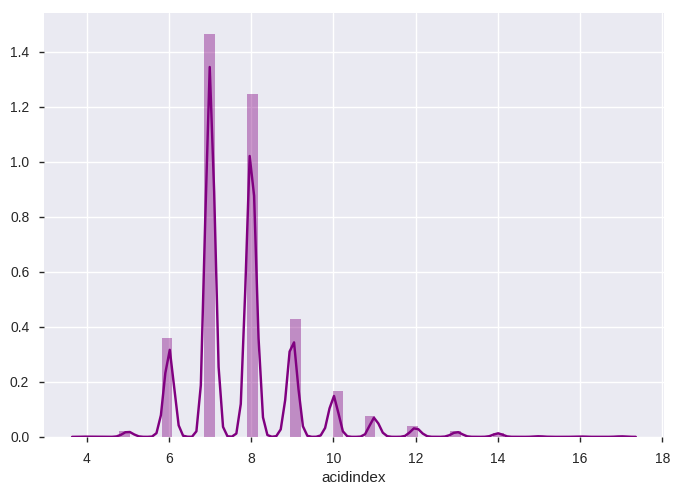

In [31]:
sns.distplot(train.acidindex, color="purple")

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


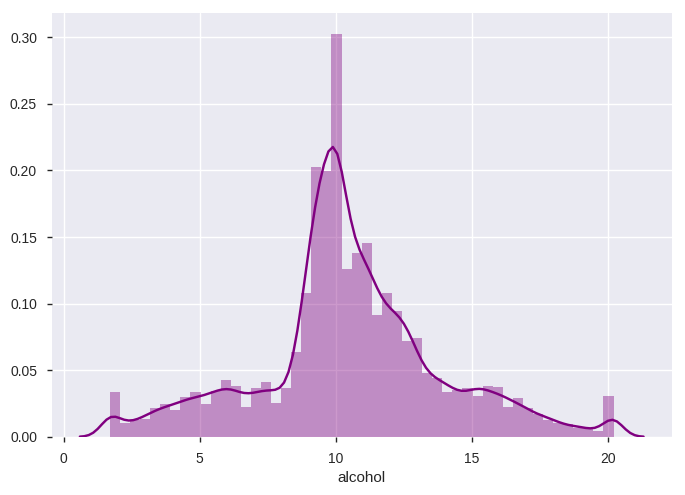

In [32]:
sns.distplot(train.alcohol, color="purple")

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


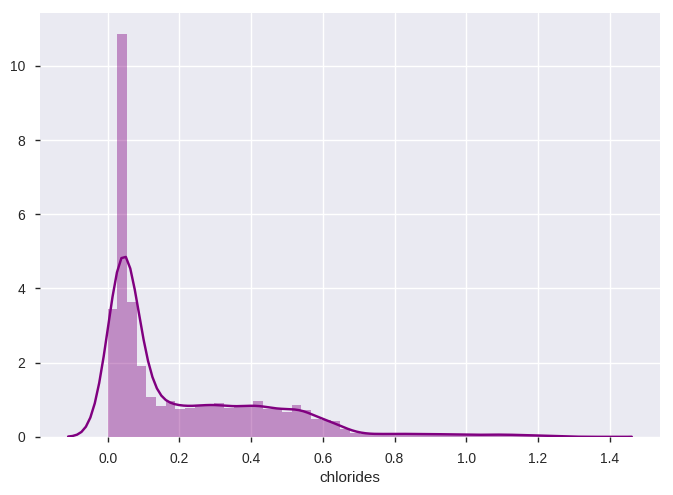

In [33]:
sns.distplot(train.chlorides, color="purple")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


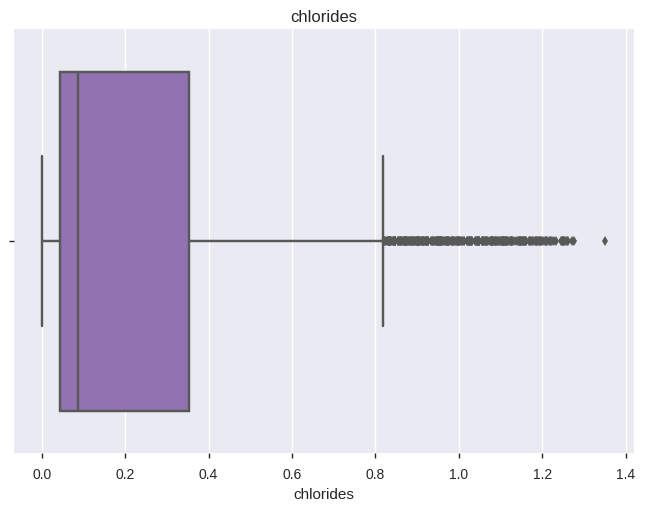

In [34]:
# boxplot of chlorides
ax = sns.boxplot(x="chlorides", data=train, color = 'tab:purple').set_title('chlorides')

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


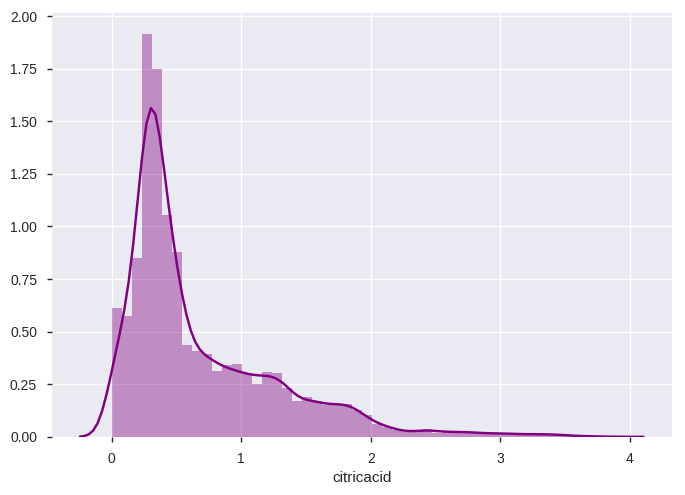

In [35]:
sns.distplot(train.citricacid, color="purple")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


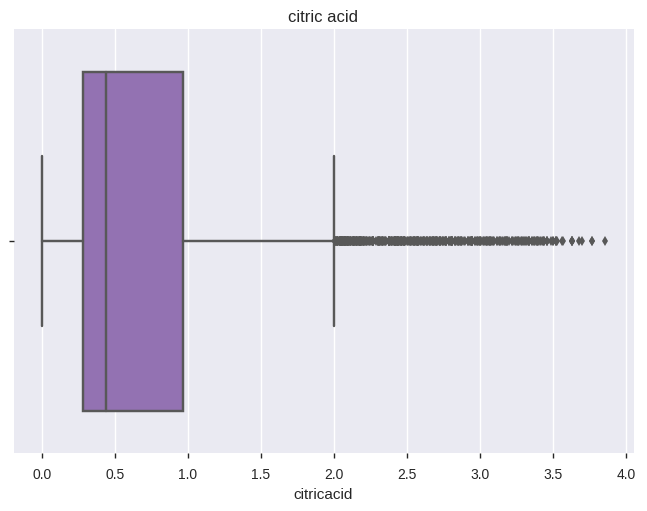

In [36]:
# boxplot of citric acid
ax = sns.boxplot(x="citricacid", data=train, color = 'tab:purple').set_title('citric acid')

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


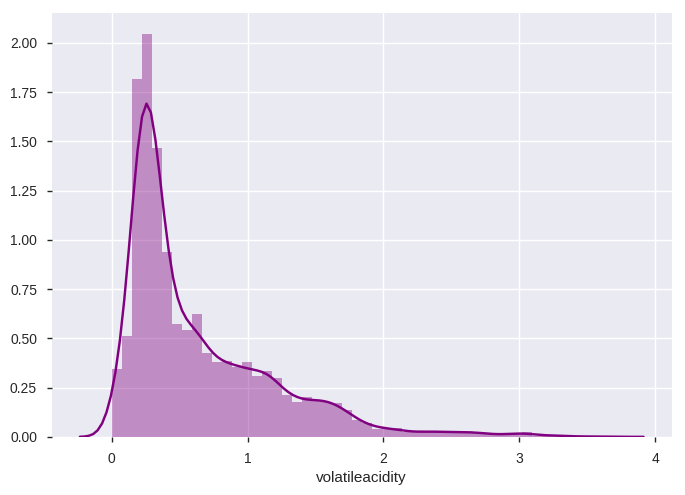

In [37]:
sns.distplot(train.volatileacidity, color="purple")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


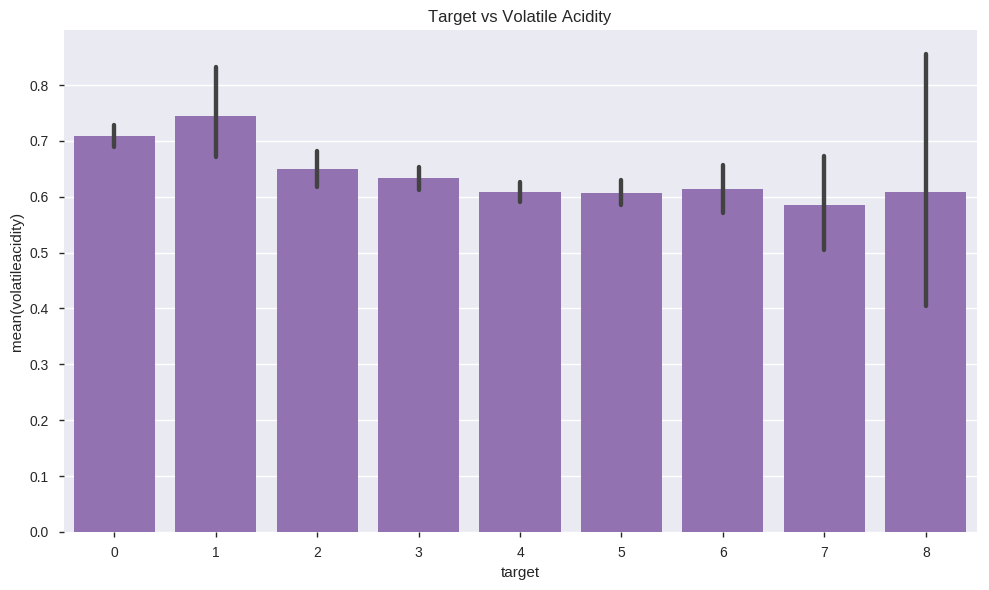

<Figure size 800x550 with 0 Axes>

In [38]:
#barplot of STARS vs Volatile Acidity
#a higher number of STARS is usually associated with lower volatile acidity levels. 
#This makes sense, because volatile acidity is an indicator of spoilage and could give rise to unpleasant aromas
fix, axs = plt.subplots(ncols=1,figsize=(10,6))
sns.barplot(x="target", y="volatileacidity", data=train, color = 'tab:purple', ax=axs)
plt.title("Target vs Volatile Acidity")

plt.tight_layout()
plt.show()
plt.gcf().clear()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


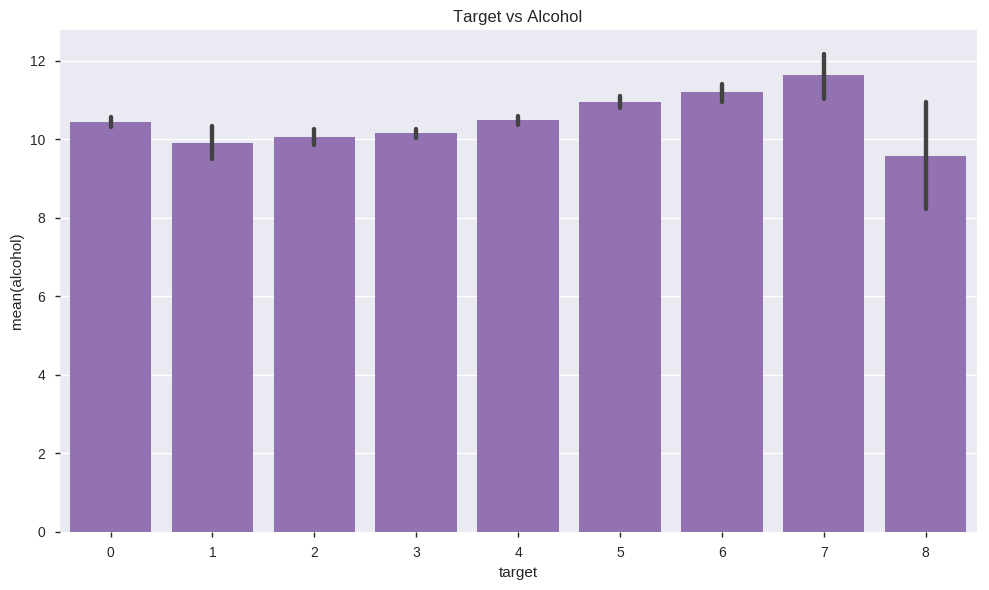

<Figure size 800x550 with 0 Axes>

In [39]:
#barplot of Target vs Alcohol
#Seems like most people generally like wines that contain a higher percentage of alcohol 
fix, axs = plt.subplots(ncols=1,figsize=(10,6))
sns.barplot(x="target", y="alcohol", data=train, color = 'tab:purple', ax=axs)
plt.title("Target vs Alcohol")

plt.tight_layout()
plt.show()
plt.gcf().clear()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


Text(0.5, 1.0, 'target vs acid index')

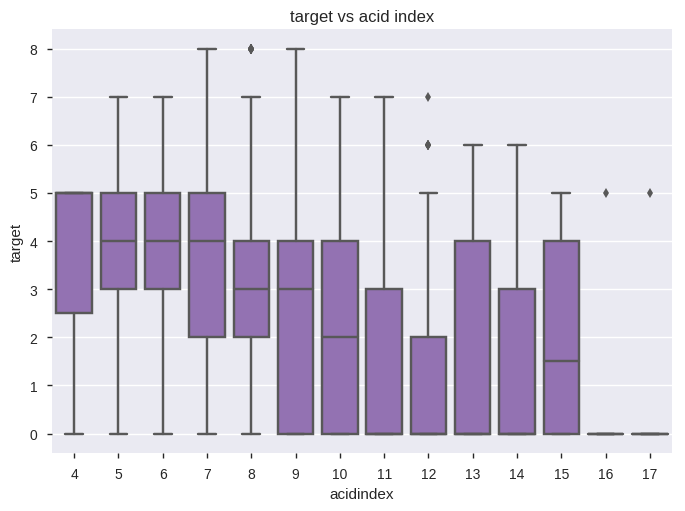

In [40]:
# boxplot of Acid Index
sns.boxplot(x="acidindex", y="target", data=train, color = 'tab:purple').set_title('target vs acid index')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


Text(0.5, 1.0, 'target vs label appeal')

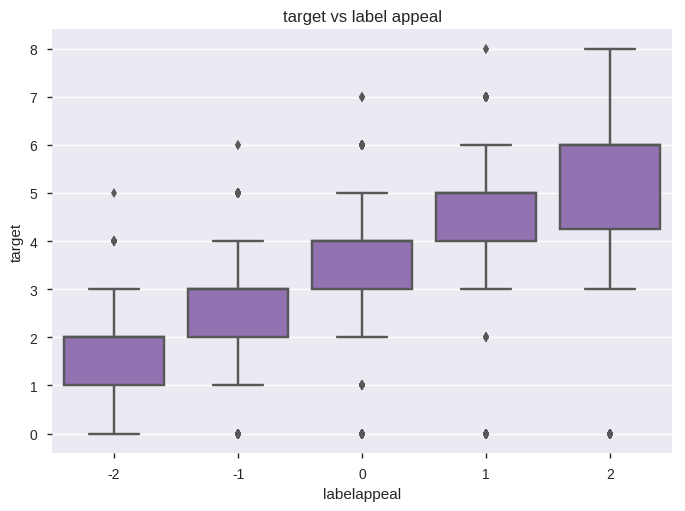

In [41]:
# boxplot of Label Appeal
sns.boxplot(x="labelappeal", y="target", color = 'tab:purple', data=train).set_title('target vs label appeal')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


Text(0.5, 1.0, 'target vs STARS')

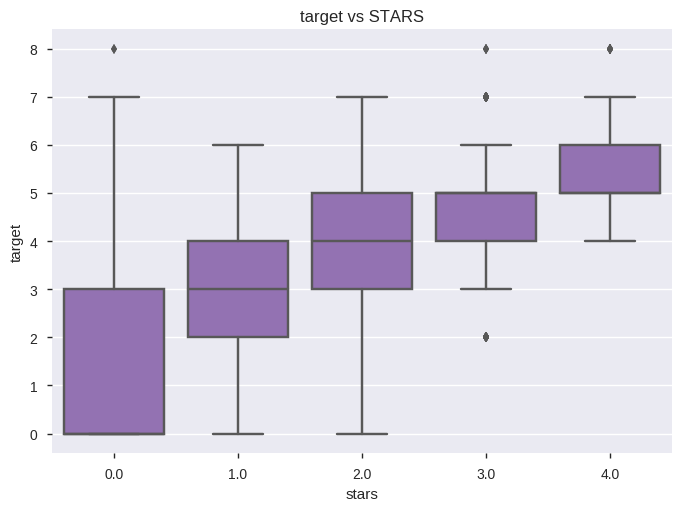

In [42]:
# boxplot of STARS
sns.boxplot(x="stars", y="target", color = 'tab:purple', data=train).set_title('target vs STARS')

In [43]:
# First we look for the highly skewed features.
numerical = train.dtypes[train.dtypes != 'object'].index

skewness = train[numerical].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

skewness_df = pd.DataFrame({'Skewness': skewness})
skewness_df.head(10)

                      Skewness
miss_va              26.605164
miss_ph               5.424413
miss_sugar            4.197837
miss_chlorides        4.117259
miss_alcohol          4.072874
miss_fsdioxide        4.061958
miss_totalsfdioxide   3.953139
miss_sulphates        2.737170
totalsulfurdioxide    1.697695
sulphates             1.695858

In [0]:
# log transform train variables
train["log_va"] = train['volatileacidity'].apply(np.log)
train["log_citricacid"] = (train['citricacid'] + 1).apply(np.log)
train["log_chlorides"] = (train['chlorides'] + 1).apply(np.log)
train["log_fsdioxide"] = (train['freesulfurdioxide'] + 1).apply(np.log)
train["log_density"] = (train['density']).apply(np.sqrt)
train["log_ph"] = train['ph'].apply(np.log)
train["log_acidindex"] = train['acidindex'].apply(np.log)
train["log_fa"] = train['fixedacidity'].apply(np.log)
train["log_sulphates"] = (train['sulphates'] + 1).apply(np.log)
train["log_totalsfdioxide"] = (train['totalsulfurdioxide'] + 1).apply(np.log)
train["log_sugar"] = (train['residualsugar'] + 1).apply(np.log)

In [0]:
# log transform test variables
test["log_va"] = test['volatileacidity'].apply(np.log)
test["log_citricacid"] = (test['citricacid'] + 1).apply(np.log)
test["log_chlorides"] = (test['chlorides'] + 1).apply(np.log)
test["log_fsdioxide"] = (test['freesulfurdioxide'] + 1).apply(np.log)
test["log_density"] = (test['density']).apply(np.sqrt)
test["log_ph"] = test['ph'].apply(np.log)
test["log_acidindex"] = test['acidindex'].apply(np.log)
test["log_fa"] = test['fixedacidity'].apply(np.log)
test["log_sulphates"] = (test['sulphates'] + 1).apply(np.log)
test["log_totalsfdioxide"] = (test['totalsulfurdioxide'] + 1).apply(np.log)
test["log_sugar"] = (test['residualsugar']+ 1).apply(np.log)

In [46]:
# calculate upper quartile for volatile acidity
upper_quartile = train.volatileacidity.quantile(q=0.75)
upper_quartile

0.91

In [47]:
# calculate lower quartile for volatile acidity
lower_quartile = train.volatileacidity.quantile(q=0.25)
lower_quartile

0.25

In [0]:
# create new variables for low, medium, and hi volatile acidity to test
train['low_va'] = (train['volatileacidity'] <= lower_quartile)
train.low_va = train.low_va.astype(int)
train['med_va'] = (train['volatileacidity'] > lower_quartile) & (train['volatileacidity'] < upper_quartile)
train.med_va = train.med_va.astype(int)
train['hi_va'] = (train['volatileacidity'] >= upper_quartile)
train.hi_va = train.hi_va.astype(int)

In [0]:
# add new variables for low, medium, and hi volatile acidity to test
test['low_va'] = (test['volatileacidity'] <= lower_quartile)
test.low_va = test.low_va.astype(int)
test['med_va'] = (test['volatileacidity'] > lower_quartile) & (test['volatileacidity'] < upper_quartile)
test.med_va = test.med_va.astype(int)
test['hi_va'] = (test['volatileacidity'] >= upper_quartile)
test.hi_va = test.hi_va.astype(int)

In [50]:
# calculate upper quartile for fixed acidity
upper_quartile = train.fixedacidity.quantile(q=0.90)
upper_quartile

15.7

In [51]:
# calculate lower quartile for fixed acidity
lower_quartile = train.fixedacidity.quantile(q=0.10)
lower_quartile

2.2

In [0]:
# create new variables for low, medium, and hi fixed acidity to train
train['low_fa'] = (train['fixedacidity'] <= lower_quartile)
train.low_fa = train.low_fa.astype(int)
train['med_fa'] = (train['fixedacidity'] > lower_quartile) & (train['fixedacidity'] < upper_quartile)
train.med_fa = train.med_fa.astype(int)
train['hi_fa'] = (train['fixedacidity'] >= upper_quartile)
train.hi_fa = train.hi_fa.astype(int)

In [0]:
# create new variables for low, medium, and hi fixed acidity to test
test['low_fa'] = (test['fixedacidity'] <= lower_quartile)
test.low_fa = test.low_fa.astype(int)
test['med_fa'] = (test['fixedacidity'] > lower_quartile) & (test['fixedacidity'] < upper_quartile)
test.med_fa = test.med_fa.astype(int)
test['hi_fa'] = (test['fixedacidity'] >= upper_quartile)
test.hi_fa = test.hi_fa.astype(int)

In [54]:
# calculate upper quartile for alcohol
upper_quartile = train.alcohol.quantile(q=0.75)
upper_quartile

12.2

In [55]:
# calculate lower quartile for alcohol
lower_quartile = train.alcohol.quantile(q=0.25)
lower_quartile

9.1

In [0]:
# create new variables for low, medium, and hi alcohol to train
train['low_alcohol'] = (train['alcohol'] <= lower_quartile)
train.low_alcohol = train.low_alcohol.astype(int)
train['med_alcohol'] = (train['alcohol'] > lower_quartile) & (train['alcohol'] < upper_quartile)
train.med_alcohol = train.med_alcohol.astype(int)
train['hi_alcohol'] = (train['alcohol'] >= upper_quartile)
train.hi_alcohol = train.hi_alcohol.astype(int)

In [0]:
# create new variables for low, medium, and hi alcohol to test
test['low_alcohol'] = (test['alcohol'] <= lower_quartile)
test.low_alcohol = test.low_alcohol.astype(int)
test['med_alcohol'] = (test['alcohol'] > lower_quartile) & (test['alcohol'] < upper_quartile)
test.med_alcohol = test.med_alcohol.astype(int)
test['hi_alcohol'] = (test['alcohol'] >= upper_quartile)
test.hi_alcohol = test.hi_alcohol.astype(int)

In [58]:
# calculate upper quartile for chlorides
upper_quartile = train.chlorides.quantile(q=0.75)
upper_quartile

0.353

In [59]:
# calculate lower quartile for fixed acidity
lower_quartile = train.chlorides.quantile(q=0.25)
lower_quartile

0.043

In [0]:
# create new variables for low, medium, and hi chlorides to train
train['low_chlorides'] = (train['chlorides'] <= lower_quartile)
train.low_chlorides = train.low_chlorides.astype(int)
train['med_chlorides'] = (train['chlorides'] > lower_quartile) & (train['chlorides'] < upper_quartile)
train.med_chlorides = train.med_chlorides.astype(int)
train['hi_chlorides'] = (train['chlorides'] >= upper_quartile)
train.hi_chlorides = train.hi_chlorides.astype(int)

In [0]:
# create new variables for low, medium, and hi chlorides to test
test['low_chlorides'] = (test['chlorides'] <= lower_quartile)
test.low_chlorides = test.low_chlorides.astype(int)
test['med_chlorides'] = (test['chlorides'] > lower_quartile) & (test['chlorides'] < upper_quartile)
test.med_chlorides = test.med_chlorides.astype(int)
test['hi_chlorides'] = (test['chlorides'] >= upper_quartile)
test.hi_chlorides = test.hi_chlorides.astype(int)

In [0]:
# convert STARS to flag variables in train for regression
train['stars_0'] = (train['stars'] == 0)
train.stars_0 = train.stars_0.astype(int)
train['stars_1'] = (train['stars'] == 1)
train.stars_1 = train.stars_1.astype(int)
train['stars_2'] = (train['stars'] == 2)
train.stars_2 = train.stars_2.astype(int)
train['stars_3'] = (train['stars'] == 3)
train.stars_3 = train.stars_3.astype(int)
train['stars_4'] = (train['stars'] == 4)
train.stars_4 = train.stars_4.astype(int)

In [0]:
# add STARS to flag variables in test
test['stars_0'] = (test['stars'] == 0)
test.stars_0 = test.stars_0.astype(int)
test['stars_1'] = (test['stars'] == 1)
test.stars_1 = test.stars_1.astype(int)
test['stars_2'] = (test['stars'] == 2)
test.stars_2 = test.stars_2.astype(int)
test['stars_3'] = (test['stars'] == 3)
test.stars_3 = test.stars_3.astype(int)
test['stars_4'] = (test['stars'] == 4)
test.stars_4 = test.stars_4.astype(int)

In [0]:
# convert acid index to flag variables in train for regression
train['acidindex_4'] = (train['acidindex'] == 4)
train.acidindex_4 = train.acidindex_4.astype(int)
train['acidindex_5'] = (train['acidindex'] == 5)
train.acidindex_5 = train.acidindex_5.astype(int)
train['acidindex_6'] = (train['acidindex'] == 6)
train.acidindex_6 = train.acidindex_6.astype(int)
train['acidindex_7'] = (train['acidindex'] == 7)
train.acidindex_7 = train.acidindex_7.astype(int)
train['acidindex_8'] = (train['acidindex'] == 8)
train.acidindex_8 = train.acidindex_8.astype(int)

In [0]:
# convert acid index to flag variables in test for regression
test['acidindex_4'] = (test['acidindex'] == 4)
test.acidindex_4 = test.acidindex_4.astype(int)
test['acidindex_5'] = (test['acidindex'] == 5)
test.acidindex_5 = test.acidindex_5.astype(int)
test['acidindex_6'] = (test['acidindex'] == 6)
test.acidindex_6 = test.acidindex_6.astype(int)
test['acidindex_7'] = (test['acidindex'] == 7)
test.acidindex_7 = test.acidindex_7.astype(int)
test['acidindex_8'] = (test['acidindex'] == 8)
test.acidindex_8 = test.acidindex_7.astype(int)

In [0]:
# create new pH variables for train
train['ph1'] = (train['ph'] <= 1.50841045)
train.ph1 = train.ph1.astype(int)
train['ph2'] = (train['ph'] > 1.50841045) & (train['ph'] < 2.18809755)
train.ph2 = train.ph2.astype(int)
train['ph3'] = (train['ph'] > 2.18809755) & (train['ph'] < 2.86778465)
train.ph3 = train.ph3.astype(int)
train['ph4'] = (train['ph'] > 2.86778465) & (train['ph'] < 3.54747175)
train.ph4 = train.ph4.astype(int)
train['ph5'] = (train['ph'] > 3.54747175) & (train['ph'] < 4.22715885)
train.ph5 = train.ph5.astype(int)
train['ph6'] = (train['ph'] > 4.22715885) & (train['ph'] < 4.90684595)
train.ph6 = train.ph6.astype(int)
train['ph7'] = (train['ph'] >= 4.90684595)
train.ph7 = train.ph7.astype(int)

In [0]:
# add new pH variables to test
test['ph1'] = (test['ph'] <= 1.50841045)
test.ph1 = test.ph1.astype(int)
test['ph2'] = (test['ph'] > 1.50841045) & (test['ph'] < 2.18809755)
test.ph2 = test.ph2.astype(int)
test['ph3'] = (test['ph'] > 2.18809755) & (test['ph'] < 2.86778465)
test.ph3 = test.ph3.astype(int)
test['ph4'] = (test['ph'] > 2.86778465) & (test['ph'] < 3.54747175)
test.ph4 = test.ph4.astype(int)
test['ph5'] = (test['ph'] > 3.54747175) & (test['ph'] < 4.22715885)
test.ph5 = test.ph5.astype(int)
test['ph6'] = (test['ph'] > 4.22715885) & (test['ph'] < 4.90684595)
test.ph6 = test.ph6.astype(int)
test['ph7'] = (test['ph'] >= 4.90684595)
test.ph7 = test.ph7.astype(int)

In [0]:
# convert va to flag variables in train for regression
train['ca_0'] = (train['citricacid'] == 0)
train.ca_0 = train.ca_0.astype(int)

In [0]:
# convert va to flag variables in test for regression
test['ca_0'] = (test['citricacid'] == 0)
test.ca_0 = test.ca_0.astype(int)

In [0]:
# convert va to flag variables in train for regression
train['va_0'] = (train['volatileacidity'] == 0)
train.va_0 = train.va_0.astype(int)

In [0]:
# convert va to flag variables in test for regression
test['va_0'] = (test['volatileacidity'] == 0)
test.va_0 = test.va_0.astype(int)

In [0]:
# New ratio variables to train
train["brix_ratio"] = (train['residualsugar']/train['acidindex'])

In [0]:
# New ratio variables to test
test["brix_ratio"] = (test['residualsugar']*test['acidindex'])

In [0]:
# New variable for total acid?
train["total_acid"] = (train['citricacid']+test['fixedacidity']+train['volatileacidity'])

In [0]:
# Add variable for total acid?
test["total_acid"] = (test['citricacid']+test['fixedacidity']+test['volatileacidity'])

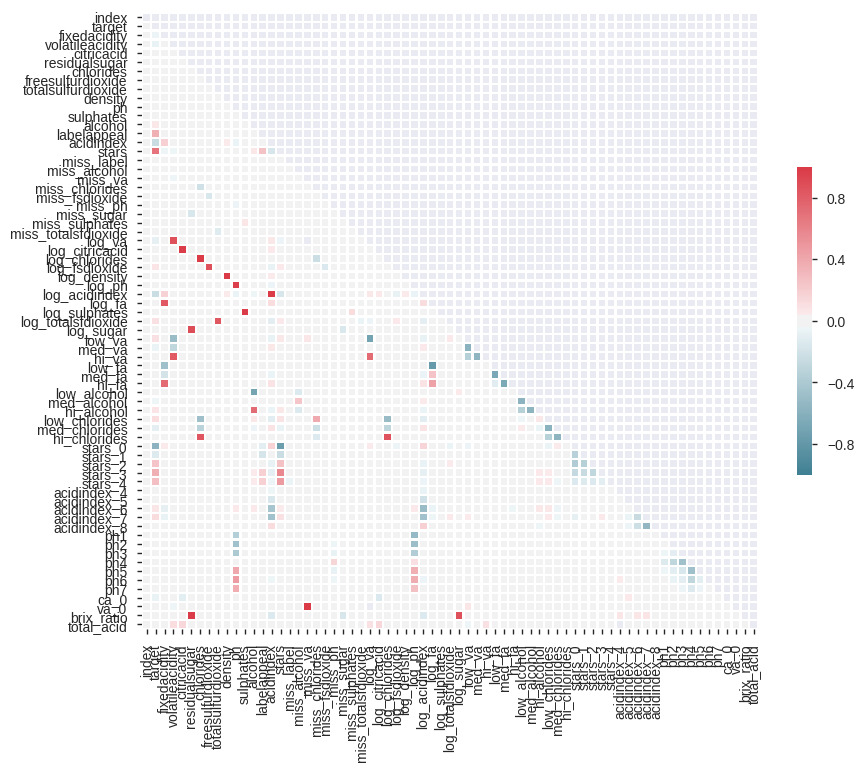

In [76]:
# Create a heatmap to check for correlated variables
# Compute the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
        square=True, linewidths=1, xticklabels = True, yticklabels = True, cbar_kws={"shrink": .5})

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


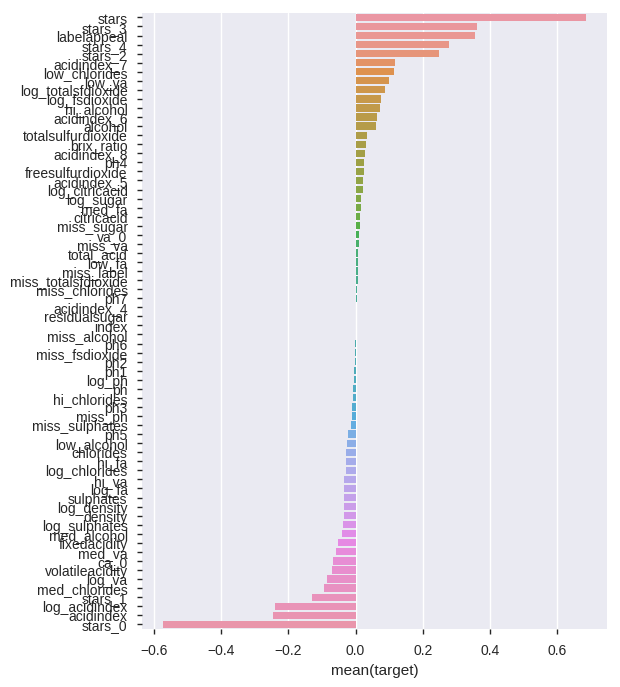

In [77]:
# Features sorted by correlation to target, from positive to negative
corr = corr.sort_values('target', ascending=False)
plt.figure(figsize=(6,8))
sns.barplot( corr.target[1:], corr.index[1:], orient='h')
plt.show()

In [0]:
# Shell code model
y = train['target']
X = train[["residualsugar","chlorides","freesulfurdioxide","totalsulfurdioxide","alcohol"]].copy()
X["intercept"] = 1

In [79]:
X_test = test[["residualsugar","chlorides","freesulfurdioxide","totalsulfurdioxide","alcohol"]].copy()
X_test["intercept"] = 1
X_test.head()
X.head()

   residualsugar  chlorides  freesulfurdioxide  totalsulfurdioxide  alcohol  intercept
0           54.2      0.567               31.0               268.0      9.9          1
1           26.1      0.425               15.0               327.0     10.0          1
2           14.8      0.037              214.0               142.0     20.2          1
3           18.8      0.425               22.0               115.0      6.2          1
4            9.4      0.000              167.0               108.0     13.7          1

(array([  10.,   89.,  287.,  763., 1011.,  697.,  278.,  147.,   38.,
          15.]),
 array([2.52498875, 2.63560918, 2.74622961, 2.85685005, 2.96747048,
        3.07809092, 3.18871135, 3.29933179, 3.40995222, 3.52057265,
        3.63119309]),
 <a list of 10 Patch objects>)

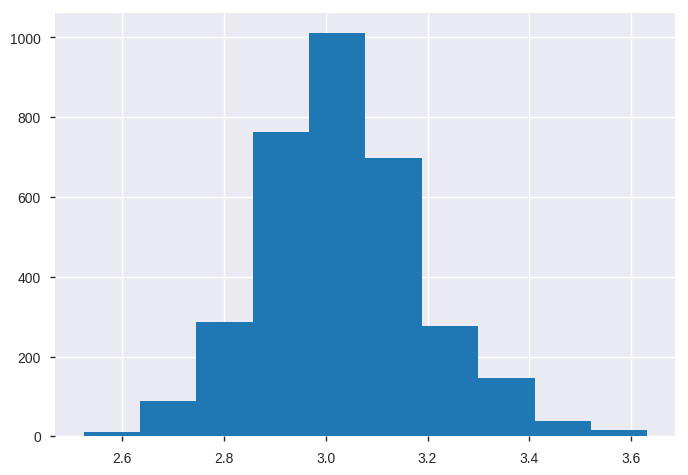

In [80]:
# model3 1: for Negative Binomial distribution
model3 = sm.NegativeBinomial(y, X).fit(disp=0)
result3 = model3.predict(X)
result3.head()
test_predictions3 = model3.predict(X_test)
test_predictions3.head()
plt.hist(test_predictions3)

In [81]:
print(model3.summary2())

                    Results: NegativeBinomial
Model:               NegativeBinomial Pseudo R-squared: 0.001     
Dependent Variable:  target           AIC:              54272.2641
Date:                2019-02-23 01:25 BIC:              54324.4617
No. Observations:    12795            Log-Likelihood:   -27129.   
Df Model:            5                LL-Null:          -27165.   
Df Residuals:        12789            Scale:            1.0000    
Converged:           1.0000                                       
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
residualsugar       0.0001   0.0002  0.2595 0.7953 -0.0004  0.0006
chlorides          -0.0746   0.0260 -2.8712 0.0041 -0.1254 -0.0237
freesulfurdioxide   0.0001   0.0001  2.5055 0.0122  0.0000  0.0003
totalsulfurdioxide  0.0001   0.0000  3.6817 0.0002  0.0001  0.0002
alcohol         

In [0]:
y = train['target']
X = train[["ph4","med_chlorides","log_totalsfdioxide","alcohol","log_fsdioxide","log_sulphates","volatileacidity","labelappeal","miss_label","acidindex","log_acidindex","low_va","hi_va","ca_0","stars_0","stars_2","stars_3","stars_4"]].copy()
X["intercept"] = 1

In [83]:
X_test = test[["ph4","med_chlorides","log_totalsfdioxide","alcohol","log_fsdioxide","log_sulphates","volatileacidity","labelappeal","miss_label","acidindex","log_acidindex","low_va","hi_va","ca_0","stars_0","stars_2","stars_3","stars_4"]].copy()
X_test["intercept"] = 1
X_test.head()
X.head()

   ph4  med_chlorides  log_totalsfdioxide  alcohol  log_fsdioxide  log_sulphates  volatileacidity  labelappeal  \
0    1              0            5.594711      9.9       3.465736       0.463734            1.160            0   
1    1              0            5.793014     10.0       2.772589       0.530628            0.160           -1   
2    1              0            4.962845     20.2       5.370638       0.392042            2.640           -1   
3    0              0            4.753590      6.2       3.135494       1.040277            0.385           -1   
4    1              0            4.691348     13.7       5.123964       1.018847            0.330            0   

   miss_label  acidindex  log_acidindex  low_va  hi_va  ca_0  stars_0  stars_2  stars_3  stars_4  intercept  
0           1          8       2.079442       0      1     0        0        1        0        0          1  
1           0          7       1.945910       1      0     0        0        0        1        

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(array([228., 640., 366., 602., 504., 557., 281., 116.,  33.,   8.]),
 array([0.30556028, 1.04099886, 1.77643744, 2.51187602, 3.24731461,
        3.98275319, 4.71819177, 5.45363035, 6.18906893, 6.92450752,
        7.6599461 ]),
 <a list of 10 Patch objects>)

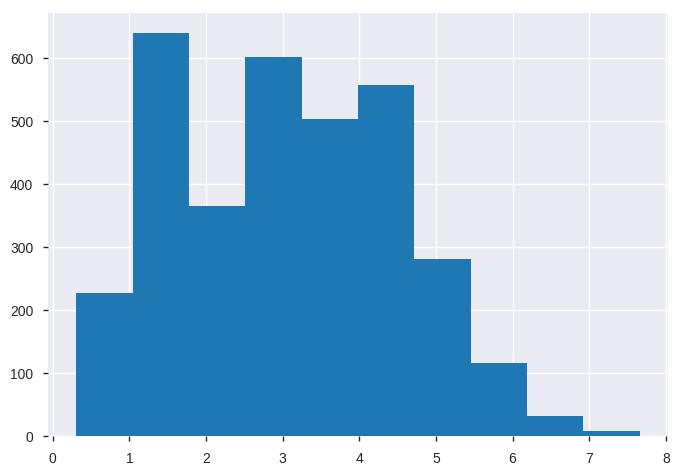

In [84]:
#model for Negative Binomial distribution
model = sm.NegativeBinomial(y, X).fit(disp=0)
result = model.predict(X)
result.head()
test_predictions = model.predict(X_test)
test_predictions.head()
plt.hist(test_predictions)

In [85]:
print(model.summary2())
print('Parameters: ', model.params)
print('Standard errors: ', model.bse)
print('P-values: ', model.pvalues)
print('AIC: ', model.aic)

                     Results: NegativeBinomial
Model:                NegativeBinomial Pseudo R-squared: 0.164     
Dependent Variable:   target           AIC:              45472.8350
Date:                 2019-02-23 01:25 BIC:              45621.9712
No. Observations:     12795            Log-Likelihood:   -22716.   
Df Model:             18               LL-Null:          -27165.   
Df Residuals:         12776            Scale:            1.0000    
Converged:            0.0000                                       
-------------------------------------------------------------------
                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
ph4                 0.0190   0.0103   1.8403 0.0657 -0.0012  0.0392
med_chlorides      -0.0512   0.0103  -4.9925 0.0000 -0.0713 -0.0311
log_totalsfdioxide  0.0257   0.0061   4.1932 0.0000  0.0137  0.0377
alcohol             0.0046   0.0015   3.0764 0.0021  0.0017  0.0075
l

In [0]:
#Convert the array predictions to a data frame then merge with the index for the test data to create your file
d = {'p_target': test_predictions}
df1 = test[['index']]
df2=pd.DataFrame(data=d)
your_file = pd.concat([df1,df2],axis = 1, join_axes=[df1.index])
#Submit your file as csv using the following code to save on your computer 
#You will have to delete the first column in the csv file to submit to kaggle
# your_file.to_csv('/Users/predictions.csv')

(array([228., 640., 366., 602., 505., 556., 282., 115.,  33.,   8.]),
 array([0.30574221, 1.04117564, 1.77660907, 2.5120425 , 3.24747593,
        3.98290936, 4.71834279, 5.45377622, 6.18920965, 6.92464308,
        7.66007651]),
 <a list of 10 Patch objects>)

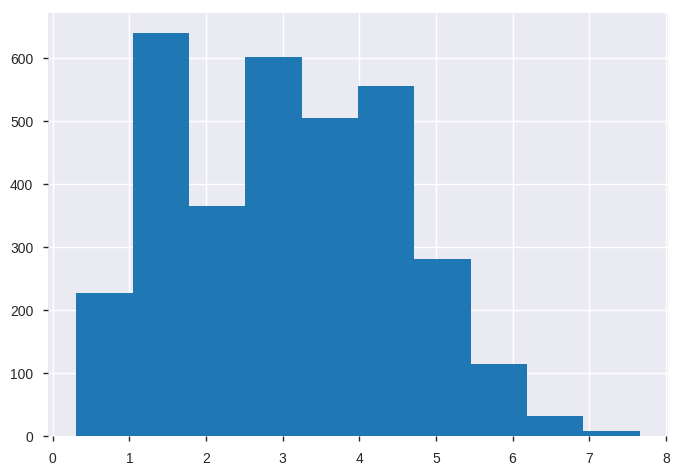

In [89]:
#model for Poisson distribution
model2 = sm.Poisson(y, X).fit(disp=0)
result2 = model2.predict(X)
result2.head()
test_predictions2 = model2.predict(X_test)
test_predictions2.head()
plt.hist(test_predictions2)

In [90]:
print(model2.summary2())

                         Results: Poisson
Model:                Poisson          No. Iterations:   9.0000    
Dependent Variable:   target           Pseudo R-squared: 0.171     
Date:                 2019-02-23 01:27 AIC:              45470.8315
No. Observations:     12795            BIC:              45612.5109
Df Model:             18               Log-Likelihood:   -22716.   
Df Residuals:         12776            LL-Null:          -27401.   
Converged:            1.0000           Scale:            1.0000    
-------------------------------------------------------------------
                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
ph4                 0.0190   0.0103   1.8398 0.0658 -0.0012  0.0392
med_chlorides      -0.0512   0.0103  -4.9913 0.0000 -0.0713 -0.0311
log_totalsfdioxide  0.0257   0.0061   4.1928 0.0000  0.0137  0.0377
alcohol             0.0046   0.0015   3.0766 0.0021  0.0017  0.0075
log_fs

In [91]:
#Just for fun try some other models and compare MSE
train_predictions = model.predict(X)
from sklearn.metrics import mean_squared_error
mean_squared_error(train_predictions, train['target'])

1.6707774646966764

In [0]:
from sklearn.ensemble import RandomForestRegressor
# Initialize the model with some parameters.
RFmodel = RandomForestRegressor(n_estimators=100, min_samples_leaf=10, random_state=1)

In [93]:
# Fit the model to the data.
RFmodel.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [0]:
# Make predictions.
RFpredictions = RFmodel.predict(X)

(array([ 889., 1282., 1517., 1716., 1846., 2041., 1803., 1127.,  477.,
          97.]),
 array([0.01778979, 0.69653397, 1.37527815, 2.05402233, 2.73276651,
        3.41151069, 4.09025487, 4.76899905, 5.44774323, 6.12648741,
        6.80523159]),
 <a list of 10 Patch objects>)

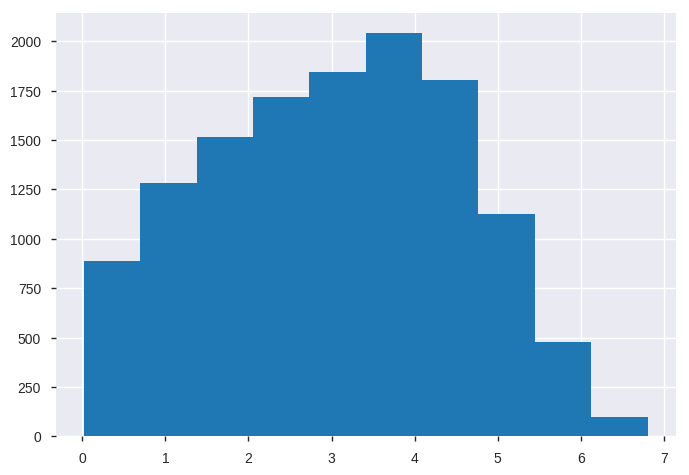

In [95]:
# Compute the error.
mean_squared_error(RFpredictions, train['target'])
plt.hist(RFpredictions)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


(array([2734.,  244., 1091., 2611.,    0., 3177., 2014.,  765.,  142.,
          17.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

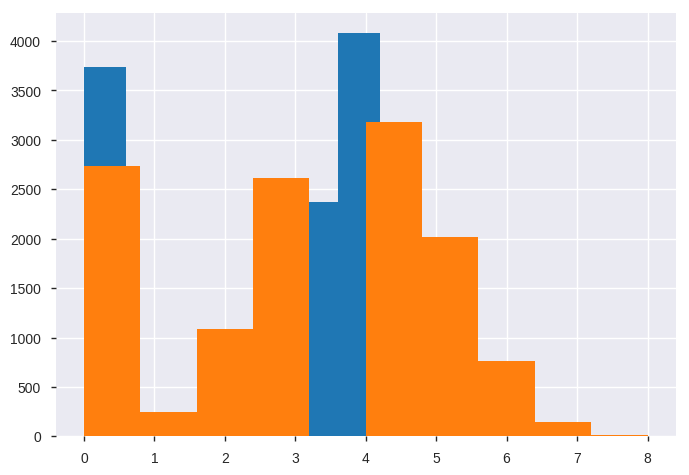

In [96]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X, y)
SVCpredictions = clf.predict(X)
mean_squared_error(SVCpredictions, train['target'])
plt.hist(SVCpredictions)
plt.hist(train['target'])

In [97]:
#And more ways to compare models
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
print(accuracy_score(y,SVCpredictions))
print(classification_report(y,SVCpredictions))
conf = confusion_matrix(y,SVCpredictions)

0.509808518952716
              precision    recall  f1-score   support

           0       0.59      0.81      0.68      2734
           1       0.67      0.01      0.02       244
           2       0.46      0.22      0.30      1091
           3       0.47      0.43      0.45      2611
           4       0.47      0.61      0.53      3177
           5       0.48      0.43      0.45      2014
           6       0.53      0.19      0.28       765
           7       0.00      0.00      0.00       142
           8       0.00      0.00      0.00        17

   micro avg       0.51      0.51      0.51     12795
   macro avg       0.41      0.30      0.30     12795
weighted avg       0.50      0.51      0.48     12795



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

NB 0.2675254104769351
KNN 0.41844696784597346
DT 0.3850718945465207
SVM 0.4893329138975762


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


[Text(0, 0, 'NB'), Text(0, 0, 'KNN'), Text(0, 0, 'DT'), Text(0, 0, 'SVM')]

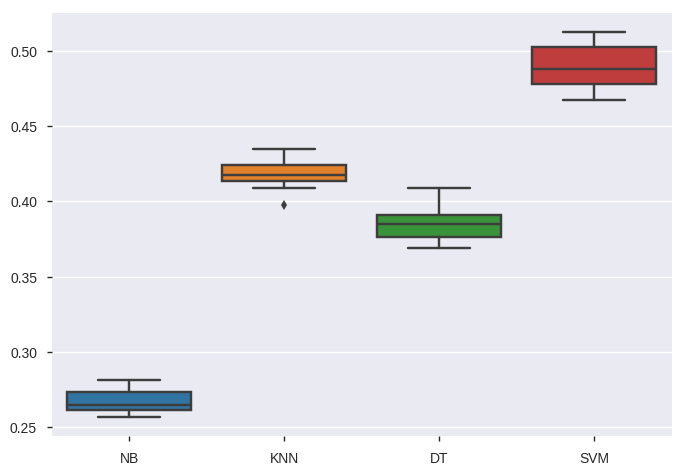

In [98]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
models = []
models.append(("NB",GaussianNB()))
models.append(("KNN",KNeighborsClassifier()))
models.append(("DT",DecisionTreeClassifier()))
models.append(("SVM",SVC()))
results = []
names = []
for name,model in models:
    kfold = KFold(n_splits=10, random_state=22)
    cv_result = cross_val_score(model,X,y, cv = kfold,scoring = "accuracy")
    names.append(name)
    results.append(cv_result)
for i in range(len(names)):
    print(names[i],results[i].mean())
ax = sns.boxplot(data=results)
ax.set_xticklabels(names)

(array([2734.,  244., 1091., 2611.,    0., 3177., 2014.,  765.,  142.,
          17.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

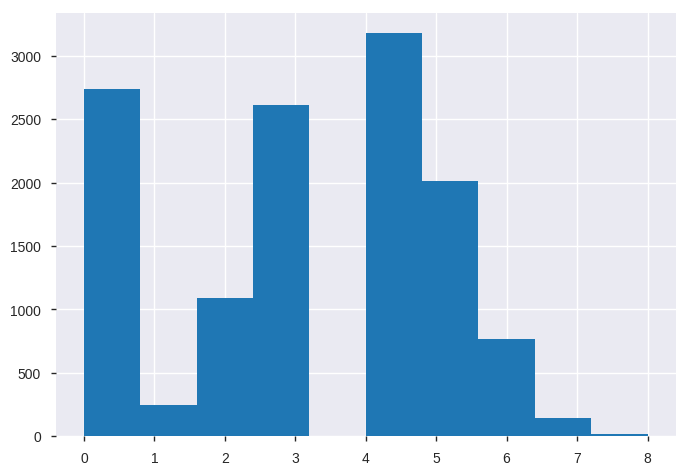

In [99]:
#look at DT
dt = DecisionTreeClassifier()
dt.fit(X, y)
DTpredictions = dt.predict(X)
mean_squared_error(DTpredictions, train['target'])
plt.hist(DTpredictions)

In [0]:
#in case you would like to turn in some other models for scoring
DTpredictions_test = dt.predict(X_test)
d = {'p_target': DTpredictions_test}
df1 = test[['index']]
df2=pd.DataFrame(data=d)
DT_file = pd.concat([df1,df2],axis = 1, join_axes=[df1.index])
# DT_file.to_csv('/Users/DTpredictions.csv')

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


(array([3.732e+03, 3.000e+00, 0.000e+00, 5.240e+02, 0.000e+00, 2.372e+03,
        4.080e+03, 0.000e+00, 1.809e+03, 2.750e+02]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

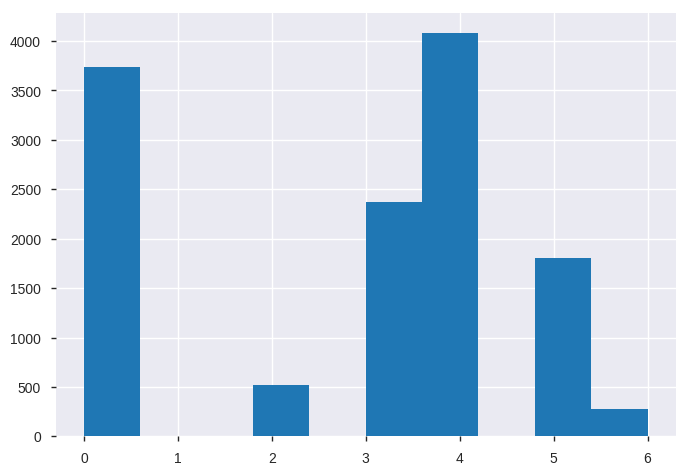

In [102]:
svc = SVC()
svc.fit(X, y)
SVCpredictions = svc.predict(X)
mean_squared_error(SVCpredictions, train['target'])
plt.hist(SVCpredictions)

In [0]:
SVCpredictions_test = svc.predict(X_test)
d = {'p_target': SVCpredictions_test}
df1 = test[['index']]
df2=pd.DataFrame(data=d)
SVC_file = pd.concat([df1,df2],axis = 1, join_axes=[df1.index])
# SVC_file.to_csv('/Users/SVCpredictions.csv')

#### Conclusion

Several models were developed and tested to predict the number of cases of wine sold using chemistry data. The best negative binomial regression model was derived using a model with select log transformed variables (total sulfur dioxide, free sulfur dioxide, sulphates, acid index), binned variables (stars, medium chlorides, low and high volatile acidity), indicator variables (missing label, citric acid = 0, stars_0), and the remaining variables with low p-values as predictors of the target. Other models were tested that resulted in similar Pseudo R-squared values, but the model selected had a low AIC, low BIC, and low RMSE. Although there were no problems detected with the various negative binomial regression models, the selected model did include variables with coefficients that should be examined. It may be advantageous to consult a sommelier or wine expert before including or eliminating these variables from the model. Additionally, through EDA we uncovered skewed variables, indicator variables, and binned variables that improved model performance. This wine dataset may potentially be leveraged for a hurdle model or a more advanced zero inflated model, but is beyond the scope of this report.